In [1]:
import os
import glob
import json
from datetime import datetime
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from scipy.stats import binom
import pandas as pd
import pingouin as pg
import re

folder_path = "study-data"

[7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7]
ShapiroResult(statistic=0.847199401036639, pvalue=6.356771286163356e-13)
0.847199401036639


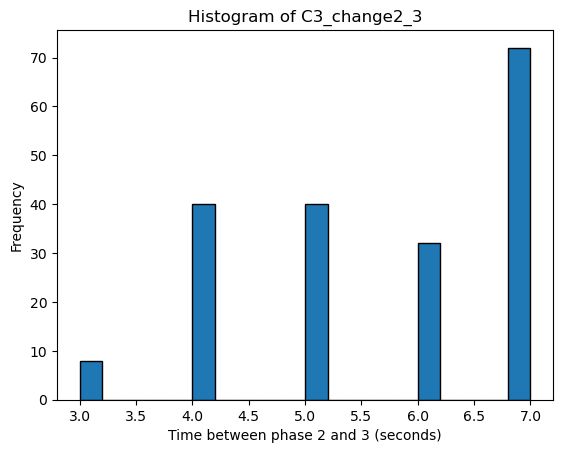

In [2]:
rows = []

C1_q1 = []
C2_q1 = []
C3_q1 = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            pid = record.get("PID", None)

            for condition in range (1, 4):
                condition_questions = record.get (f"C{condition}_questions")
                for q in range (8):
                    
                    if condition == 1:
                        C1_q1.append(condition_questions[1])
                    if condition == 2:
                        C2_q1.append(condition_questions[1])
                    if condition == 3:
                        C3_q1.append(condition_questions[1])

                    rows.append({
                        f"q{q}": condition_questions[q],
                        "PID": pid,
                        "condition": condition,
                            "source_file": os.path.basename(jsonl_path)
                        })

# Convert list of dicts to DataFrame
condition_question_data = pd.DataFrame(rows)

# Optional: Convert timestamp column to datetime
# data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# Display first few rows
condition_question_data.head()

shapiro_test = stats.shapiro(C1_q1)
print(C1_q1)
print(shapiro_test)
print(shapiro_test.statistic)

plt.hist(C1_q1, bins=20, edgecolor='black')
plt.xlabel('Time between phase 2 and 3 (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of C3_change2_3')
plt.show() 

In [3]:

aov = pg.friedman(data=condition_question_data, dv='q1', within='condition', subject='source_file')
print(aov)

             Source         W  ddof1         Q     p-unc
Friedman  condition  0.164394      2  7.890909  0.019342


In [4]:

rows = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            user_answer = record.get("user_answer", {})
            pid = record.get("PID", None)

            # Unpack user_answer entries
            for question_key, value in user_answer.items():
                if not isinstance(value, list) or len(value) != 2:
                    print(f"Unexpected format for {question_key} in file {jsonl_path}")
                    continue

                timestamp, answer = value

                rows.append({
                    "question": question_key,
                    "timestamp": timestamp,
                    "answer": answer,
                    "PID": pid,
                    "source_file": os.path.basename(jsonl_path)
                })

# Convert list of dicts to DataFrame
data = pd.DataFrame(rows)

# Optional: Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# Display first few rows
data.head()
            


,question,timestamp,answer,PID,source_file
0,7first_choiceC3,2025-07-17 15:00:19.598041,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
1,7second_choiceC3,2025-07-17 15:00:16.851518,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
2,7third_choiceC3,2025-07-17 15:00:27.078233,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
3,1first_choiceC3,2025-07-17 15:01:08.913367,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl
4,1second_choiceC3,2025-07-17 15:01:28.387955,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl


             Source         W  ddof1         Q     p-unc
Friedman  condition  0.002874      2  0.137931  0.933359


/var/folders/sd/q3bdfk5n2y37dmtz66bqjxtc0000gp/T/ipykernel_9932/695753565.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette='pastel')
/var/folders/sd/q3bdfk5n2y37dmtz66bqjxtc0000gp/T/ipykernel_9932/695753565.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette='pastel')


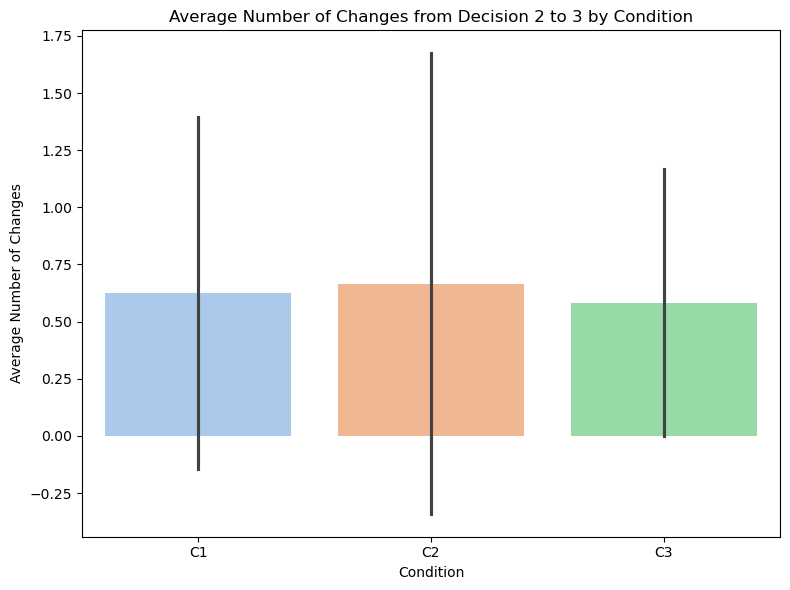

In [5]:
rows = []

participant = []
conditions = []
time = []
C1_time2_3 = []
C2_time2_3 = []
C3_time2_3 = []

C1_change2_3 = []
C2_change2_3 = []
C3_change2_3 = []


for src_file in data['source_file'].unique():
    C1_counter = 0
    C2_counter = 0
    C3_counter = 0

    for q in range(1, 13):
        for condition in range(1, 4):
            first_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}first_choiceC{condition}")]
            second_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}second_choiceC{condition}")]
            third_choice = data.loc[(data['source_file'] == src_file) & (data['question']== f"{q}third_choiceC{condition}")]

            if second_choice.shape[0] < 1 or third_choice.shape[0] < 1:
                continue
        
            t1 = first_choice.iloc[0]['timestamp']
            t2 = second_choice.iloc[0]['timestamp']
            t3 = third_choice.iloc[0]['timestamp']
            if pd.notnull(t1) and pd.notnull(t2):
                participant.append(src_file)
                conditions.append(f"C{condition}")
                # time taken between phase 3 and phase 2 CHANGE HERE TO CALCULATE TIME BETWEEN phase 1 and phase 2
                if condition == 1 and (second_choice.iloc[0]['answer']!= third_choice.iloc[0]['answer']):
                    C1_counter +=1
                if condition == 2 and (second_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C2_counter +=1
                if condition == 3 and (second_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C3_counter +=1

    C1_change2_3.append(C1_counter)
    C2_change2_3.append(C2_counter)
    C3_change2_3.append(C3_counter)

    rows.append({
        "change": C1_counter,
        "source_file": src_file,
        "condition": "C1",
    })

    rows.append({
        "change": C2_counter,
        "source_file": src_file,
        "condition": "C2",
    })

    rows.append({
        "change": C3_counter,
        "source_file": src_file,
        "condition": "C3",
    })

change_data = pd.DataFrame(rows)

aov = pg.friedman(data=change_data, dv='change', within='condition', subject='source_file')
print(aov)

plt.figure(figsize=(8, 6))
sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette='pastel')
plt.title('Average Number of Changes from Decision 2 to 3 by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Number of Changes')
plt.tight_layout()
plt.show()

             Source         W  ddof1         Q     p-unc
Friedman  condition  0.081439      2  3.909091  0.141629


/var/folders/sd/q3bdfk5n2y37dmtz66bqjxtc0000gp/T/ipykernel_9932/2045805200.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette='pastel')
/var/folders/sd/q3bdfk5n2y37dmtz66bqjxtc0000gp/T/ipykernel_9932/2045805200.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette='pastel')


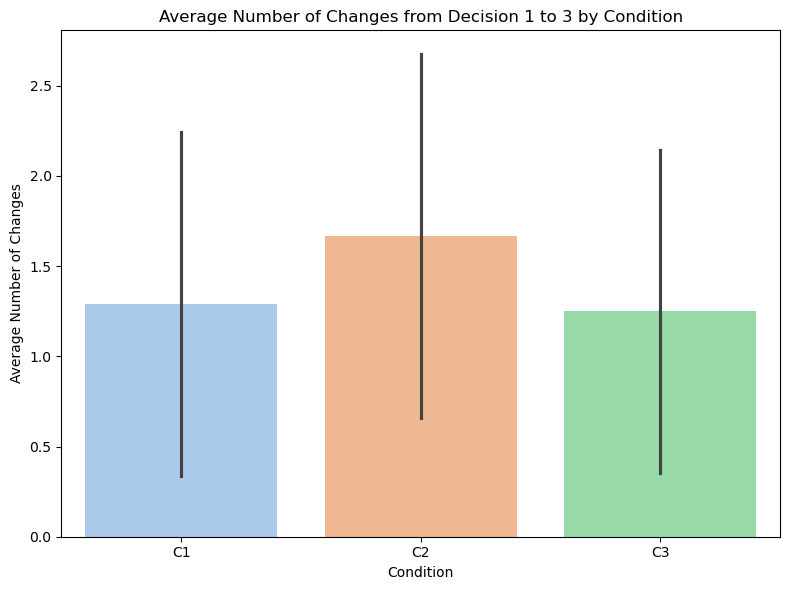

In [9]:
rows = []

participant = []
conditions = []
time = []
C1_time1_3 = []
C2_time1_3 = []
C3_time1_3 = []

C1_change1_3 = []
C2_change1_3 = []
C3_change1_3 = []


for src_file in data['source_file'].unique():
    C1_counter = 0
    C2_counter = 0
    C3_counter = 0

    for q in range(1, 13):
        for condition in range(1, 4):
            first_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}first_choiceC{condition}")]
            second_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}second_choiceC{condition}")]
            third_choice = data.loc[(data['source_file'] == src_file) & (data['question']== f"{q}third_choiceC{condition}")]

            if third_choice.shape[0] < 1 or second_choice.shape[0] < 1:
                continue
        
            t1 = first_choice.iloc[0]['timestamp']
            t2 = second_choice.iloc[0]['timestamp']
            t3 = third_choice.iloc[0]['timestamp']
            if pd.notnull(t1) and pd.notnull(t2):
                participant.append(src_file)
                conditions.append(f"C{condition}")
                # time taken between phase 3 and phase 2 CHANGE HERE TO CALCULATE TIME BETWEEN phase 1 and phase 2
                if condition == 1 and (first_choice.iloc[0]['answer']!= third_choice.iloc[0]['answer']):
                    C1_counter +=1
                if condition == 2 and (first_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C2_counter +=1
                if condition == 3 and (first_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C3_counter +=1

    C1_change1_3.append(C1_counter)
    C2_change1_3.append(C2_counter)
    C3_change1_3.append(C3_counter)

    rows.append({
        "change": C1_counter,
        "source_file": src_file,
        "condition": "C1",
    })

    rows.append({
        "change": C2_counter,
        "source_file": src_file,
        "condition": "C2",
    })

    rows.append({
        "change": C3_counter,
        "source_file": src_file,
        "condition": "C3",
    })

change_data = pd.DataFrame(rows)

aov = pg.friedman(data=change_data, dv='change', within='condition', subject='source_file')
print(aov)

plt.figure(figsize=(8, 6))
sns.barplot(data=change_data, x='condition', y='change', ci='sd', palette='pastel')
plt.title('Average Number of Changes from Decision 1 to 3 by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Number of Changes')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load the CSV (if not already loaded)
data = pd.read_csv("data.csv")

# Replace 'D2_D3_time' with your actual column name for time between decision 2 and 3
time_col = 'time2_3'

print(data['time2_3'].unique())

# Convert the column to numeric, coercing errors (e.g., 'None', NaN) to NaN
data['time2_3'] = pd.to_numeric(data['time2_3'], errors='coerce')

# Check and convert time column to numeric (in case there are strings or missing)
# data[time_col] = pd.to_numeric(data[time_col], errors='coerce')

# Drop rows where time is NaN
data_clean = data.dropna(subset=[time_col])

# Group by condition and PID, then collect times into lists
grouped = data_clean.groupby(['condition', 'PID'])[time_col].apply(list).reset_index()

# Separate each condition into its own dictionary
condition_1 = grouped[grouped['condition'] == 1][[time_col]].explode(time_col)[time_col].tolist()
condition_2 = grouped[grouped['condition'] == 2][[time_col]].explode(time_col)[time_col].tolist()
condition_3 = grouped[grouped['condition'] == 3][[time_col]].explode(time_col)[time_col].tolist()

# Output
print("Condition 1 times:", condition_1)
print("Condition 2 times:", condition_2)
print("Condition 3 times:", condition_3)


KeyError: 'time2_3'

In [ ]:
rows = []



for q in range(8):
    C1_q = []
    C2_q = []
    C3_q = []
    print(f"Question {q}:")
# Loop through all jsonl files
    for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
        with open(jsonl_path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue

                try:
                    record = json.loads(line)
                except json.JSONDecodeError:
                    print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                    continue

                pid = record.get("PID", None)

                for condition in range (1, 4):
                    condition_questions = record.get (f"C{condition}_questions")
                        
                    if condition == 1:
                        C1_q.append(condition_questions[q])
                    if condition == 2:
                        C2_q.append(condition_questions[q])
                    if condition == 3:
                        C3_q.append(condition_questions[q])

    print(len(C1_q))
    print(len(C2_q))
    print(len(C3_q))
    shapiro_test = stats.shapiro(C1_q)
    print(f"Condition 1")
    print(shapiro_test)

    print(f"Condition 2")
    shapiro_test = stats.shapiro(C2_q)
    print(shapiro_test)

    print(f"Condition 3")
    shapiro_test = stats.shapiro(C3_q)
    print(shapiro_test)

    print()                 

   

Question 0:
24
24
24
Condition 1
ShapiroResult(statistic=np.float64(0.8439975678437055), pvalue=np.float64(0.0016948807579648844))
Condition 2
ShapiroResult(statistic=np.float64(0.7935845392213801), pvalue=np.float64(0.000231812335487337))
Condition 3
ShapiroResult(statistic=np.float64(0.914755543879407), pvalue=np.float64(0.04477843234373009))

Question 1:
24
24
24
Condition 1
ShapiroResult(statistic=np.float64(0.8546764575344333), pvalue=np.float64(0.0026730382423859277))
Condition 2
ShapiroResult(statistic=np.float64(0.7772598831295234), pvalue=np.float64(0.0001280242850273667))
Condition 3
ShapiroResult(statistic=np.float64(0.8808081850910641), pvalue=np.float64(0.008627600416065181))

Question 2:
24
24
24
Condition 1
ShapiroResult(statistic=np.float64(0.894705960567556), pvalue=np.float64(0.016650365479480025))
Condition 2
ShapiroResult(statistic=np.float64(0.79486609264071), pvalue=np.float64(0.00024310679538008063))
Condition 3
ShapiroResult(statistic=np.float64(0.20897542836992

/Users/26goedhuiso/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
